# <font color='red'> <center> Fundamentals of Machine Learning </font>
## <font color='red'> <center> Gone Phishing</font>
## <font color='red'> <center> Novembre 2024</font>

In [3]:
from pandas import DataFrame, read_csv, merge, crosstab, Series
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
base_data = read_csv('PhiUSIIL_Phishing_URL_Dataset.csv')

In [5]:
len(base_data.columns)

56

## <font color='red'> Exploration du dataset </font> 

### Des variables interdites sont exclues

In [3]:
drop_columns = [
    'URLSimilarityIndex',
    'CharContinuationRate',
    'URLTitleMatchScore',
    'URLCharProb',
    'TLDLegitimateProb',
]

data = base_data.drop(columns=drop_columns)
data.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,3,1,0,...,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,2,1,0,...,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,2,2,0,...,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,3,1,0,...,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,3,1,0,...,1,0,1,244,15,34,72,1,85,1


On a désormais 51 variables, dont certaines représentent un ratio

In [4]:
data.columns

Index(['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP',
       'TLD', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation',
       'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL',
       'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL',
       'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
       'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS',
       'LineOfCode', 'LargestLineLength', 'HasTitle', 'Title',
       'DomainTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive',
       'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup',
       'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet',
       'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay',
       'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS',
       'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'label'],
      dtype='object')

### Ajout de données supplémentaires

D'après l'article "PhiUSILL : a diverse security profile empowered phising URL detection framework based on similarity index and incremental", nous proposons de rajouter une colonne qui représente le nombre d'utilisation des TLD (par exemple com).

Nous avons récupérer les données à partir de ce site https://research.domaintools.com/statistics/tld-counts/ 

In [5]:
tlds = read_csv('TLDs.csv')

df = merge(
    left=data.copy(),
    right=tlds,
    how='left',
    on='TLD'
)
df['Count'] = df['Count'].fillna(0)
df = df.drop(columns='TLD')

In [6]:
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,...,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label,Count
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,3,1,0,0,...,0,1,34,20,28,119,0,124,1,154430717.0
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,2,1,0,0,...,0,1,50,9,8,39,0,217,1,17058771.0
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,2,2,0,0,...,0,1,10,2,7,42,2,5,1,9850747.0
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,3,1,0,0,...,1,1,3,27,15,22,1,31,1,154430717.0
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,3,1,0,0,...,0,1,244,15,34,72,1,85,1,11009759.0


Ici, nous créons une nouvelle variable "Count", qui est le nombre de sites web avec le domaine donné. Par exemple, .com a le compte le plus élevé avec 154.430.717. Voir le fichier TLD_extraction.ipynb pour plus des informations. L'idée est que un site de phishing aura un domaine moins commun, un compte plus faible.

### Création de nouvelles variables à partir des variables disponibles

Le jeu de données contient plus de 50 variables. Au lieu d'enlever certaines, il pourrait être plus efficace de fusionner les variables qui sont similiaires. Ici, on prend la somme de toutes variables binaires. Ainsi, plus cette variable "IsSuspicious" est élevé, plus il y a un risque de phishing. Pour arriver à cette fin, il faut noter qu'un 1 ne représente pas de risque pour toutes les variables. Par exemple, pour la variable "HasSubmitButton", un 1 représente une augmentation de risque, cependant pour la variable "IsHTTPS", un 0 représente une augmentation de risque. Ainsi, certaines variables sont transformées pour qu'elles soient de même manière.

In [7]:
# Elles sont toutes des variables binaires.
is_suss = (
    df['IsDomainIP']
    + df['HasObfuscation']
    + (1 - df['IsHTTPS'])
    + (1 - df['HasTitle'])
    + (1 - df['HasFavicon'])
    + (1 - df['IsResponsive'])
    + df['NoOfURLRedirect']
    + (1 - df['HasDescription'])
    + df['HasExternalFormSubmit']
    + (1 - df['HasSocialNet'])
    + (1 - df['HasCopyrightInfo'])
    + df['HasHiddenFields']
    + df['HasSubmitButton']
    + df['HasPasswordField']
    + df['Bank']
    + df['Pay']
    + df['Crypto']
)
df['IsSuspicious'] = is_suss


De manière similaire, pour diminuer le nombre de variables tout en gardant certaines, on fusionne les variables liées. Ici, nous avons pris la somme de toutes les variables qui décrivent les URLs. Cependant, noter qu'excluant la variable de 'NoOfLettersInURL', on augmente le F-score; probablement parce que son échelle est beaucoup plus large que celles des autres variables.

In [8]:
# Des caractéristiques liées au URL
url_features = [
    # 'NoOfLettersInURL', 
    'NoOfDegitsInURL',
    'NoOfObfuscatedChar',
    'NoOfEqualsInURL',
    'NoOfQMarkInURL',
    'NoOfAmpersandInURL',
    'NoOfOtherSpecialCharsInURL',
]
url_feature_sum = df[url_features].sum(axis=1)

df['URLFeatureSum'] = url_feature_sum

Nous avons remarqué que la longueur de l'url est souvent égale à la longueur du domaine +7. Et que la distribution des phishing sites est élevée (89779) pour les données où le critère évoqué n'est pas rempli, alors qu'on n'a aucun 'bon site' qui n'a pas ce critère

In [9]:
df["url_diff_length"] = ((df["URLLength"] - 7) == df["DomainLength"]).astype(int)
crosstab(df["url_diff_length"], df['label'])

label,0,1
url_diff_length,,
0,89779,0
1,11166,134850


## <font color='red'> Visualisation des données</font> 

In [10]:
df.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,...,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label,Count,IsSuspicious,URLFeatureSum,url_diff_length
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,3,1,0,0,...,20,28,119,0,124,1,154430717.0,6,1,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,2,1,0,0,...,9,8,39,0,217,1,17058771.0,3,2,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,2,2,0,0,...,2,7,42,2,5,1,9850747.0,4,2,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,3,1,0,0,...,27,15,22,1,31,1,154430717.0,6,1,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,3,1,0,0,...,15,34,72,1,85,1,11009759.0,6,1,1


La plupart des variables sont numériques. Celles qui ne le sont pas ne portent pas des informations pertinentes. Par exemple l'url et le nom du domaine du site ne servira pas à l'entrainement; puisqu'ils sont uniques à chaque site. Donc, on peut garder seulement les numériques.
On ignore de cette façon aussi les TLD 

In [11]:
print(df.info())
df = df.select_dtypes(include=[float, int])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 54 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   FILENAME                    235795 non-null  object 
 1   URL                         235795 non-null  object 
 2   URLLength                   235795 non-null  int64  
 3   Domain                      235795 non-null  object 
 4   DomainLength                235795 non-null  int64  
 5   IsDomainIP                  235795 non-null  int64  
 6   TLDLength                   235795 non-null  int64  
 7   NoOfSubDomain               235795 non-null  int64  
 8   HasObfuscation              235795 non-null  int64  
 9   NoOfObfuscatedChar          235795 non-null  int64  
 10  ObfuscationRatio            235795 non-null  float64
 11  NoOfLettersInURL            235795 non-null  int64  
 12  LetterRatioInURL            235795 non-null  float64
 13  NoOfDegitsInUR

In [12]:
df.describe()

,URLLength,DomainLength,IsDomainIP,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,...,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label,Count,IsSuspicious,URLFeatureSum,url_diff_length
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,...,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,2.357950e+05,235795.000000,235795.000000,235795.000000
mean,34.573095,21.470396,0.002706,2.764456,1.164758,0.002057,0.024861,0.000138,19.428919,0.515946,...,6.333111,10.522305,65.071113,2.377629,49.262516,0.571895,7.623798e+07,4.450425,4.362769,0.619250
std,41.314153,9.150793,0.051946,0.599739,0.600969,0.045306,1.876249,0.003817,29.090330,0.123315,...,74.866296,22.312192,176.687539,17.641097,161.027430,0.494805,7.480934e+07,1.919490,17.628668,0.485572
min,13.000000,4.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,23.000000,16.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,10.000000,0.435000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.027795e+06,3.000000,1.000000,0.000000
50%,27.000000,20.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,14.000000,0.519000,...,2.000000,6.000000,12.000000,0.000000,10.000000,1.000000,1.246406e+07,5.000000,1.000000,1.000000
75%,34.000000,24.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,20.000000,0.594000,...,8.000000,15.000000,88.000000,1.000000,57.000000,1.000000,1.544307e+08,6.000000,3.000000,1.000000
max,6097.000000,110.000000,1.000000,13.000000,10.000000,1.000000,447.000000,0.348000,5191.000000,0.926000,...,35820.000000,6957.000000,27397.000000,4887.000000,27516.000000,1.000000,1.544307e+08,12.000000,3215.000000,1.000000


On voit ici un éventail des échelles pour les variables. Ainsi, on va les mettre à l'échelle avec l'analyse.

In [13]:
df.isnull().sum()

URLLength                     0
DomainLength                  0
IsDomainIP                    0
TLDLength                     0
NoOfSubDomain                 0
HasObfuscation                0
NoOfObfuscatedChar            0
ObfuscationRatio              0
NoOfLettersInURL              0
LetterRatioInURL              0
NoOfDegitsInURL               0
DegitRatioInURL               0
NoOfEqualsInURL               0
NoOfQMarkInURL                0
NoOfAmpersandInURL            0
NoOfOtherSpecialCharsInURL    0
SpacialCharRatioInURL         0
IsHTTPS                       0
LineOfCode                    0
LargestLineLength             0
HasTitle                      0
DomainTitleMatchScore         0
HasFavicon                    0
Robots                        0
IsResponsive                  0
NoOfURLRedirect               0
NoOfSelfRedirect              0
HasDescription                0
NoOfPopup                     0
NoOfiFrame                    0
HasExternalFormSubmit         0
HasSocia

Il n'y a pas de valeures manquantes.

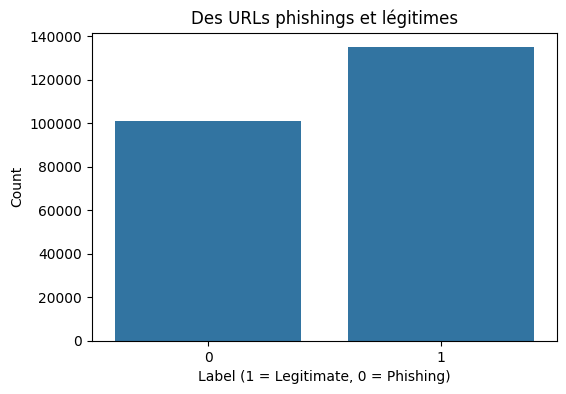

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label')
plt.title('Des URLs phishings et légitimes')
plt.xlabel('Label (1 = Legitimate, 0 = Phishing)')
plt.ylabel('Count')
plt.show()

Les données sont largement équilibrées en termes de variable ciblée. Ainsi, il ne faut pas faire top attention à certains problèmes qui s'avèrent quand les données sont déséquilibrées.

### Crosstab 

Nous avons aussi voulu explorer la distributions des données en fonction des labels.

In [15]:
pd.crosstab(df["NoOfQMarkInURL"],df['label'])


label,0,1
NoOfQMarkInURL,,
0,94815,134850
1,5572,0
2,315,0
3,241,0
4,2,0


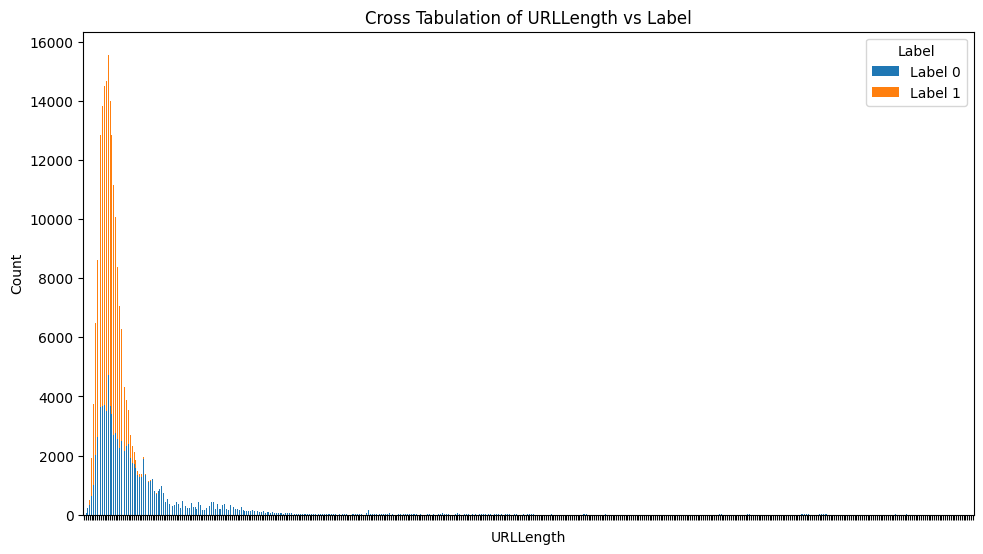

In [16]:
crosstab = pd.crosstab(df["URLLength"], df['label'])

# Création du graphique en barres empilées
ax = crosstab.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], figsize=(10, 6))
plt.title("Cross Tabulation of URLLength vs Label")
plt.xlabel("URLLength")
plt.ylabel("Count")
plt.legend(["Label 0", "Label 1"], title="Label")
# plt.xticks(rotation=45)
plt.tight_layout()
ax.set_xticklabels([])
# Affichage du graphique
plt.show()

On a remarqué que pour la plupart des variables, à partir d'une certaine valeur, on a que des phishing websites ou bien que des sites normaux selon la variable. Cela nous a donné l'intuition que le modèle d'arbre de décision pourrait être un bon candidat pour avoir de bons résultats

### Corrélation

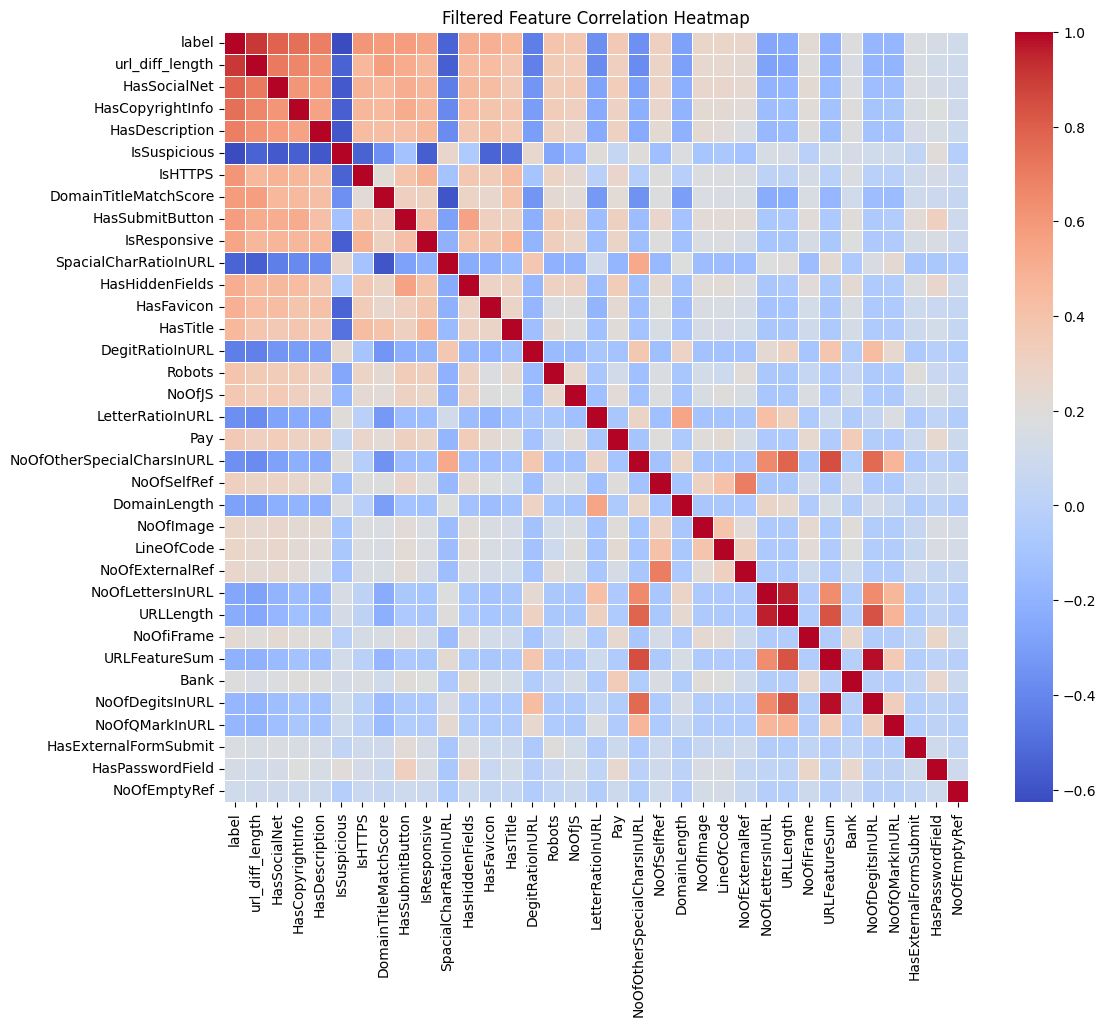

In [17]:
# Matrice de corrélation avec des colonnes numériques

correlation_matrix = df.corr()

significant_corr = correlation_matrix['label'].abs().sort_values(ascending=False)
significant_columns = significant_corr[significant_corr > 0.1].index.tolist()

# Sélectionner seulement les colonnes les plus significatives
filtered_phishing = df[significant_columns]
filtered_correlation_matrix = filtered_phishing.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Filtered Feature Correlation Heatmap')
plt.show()


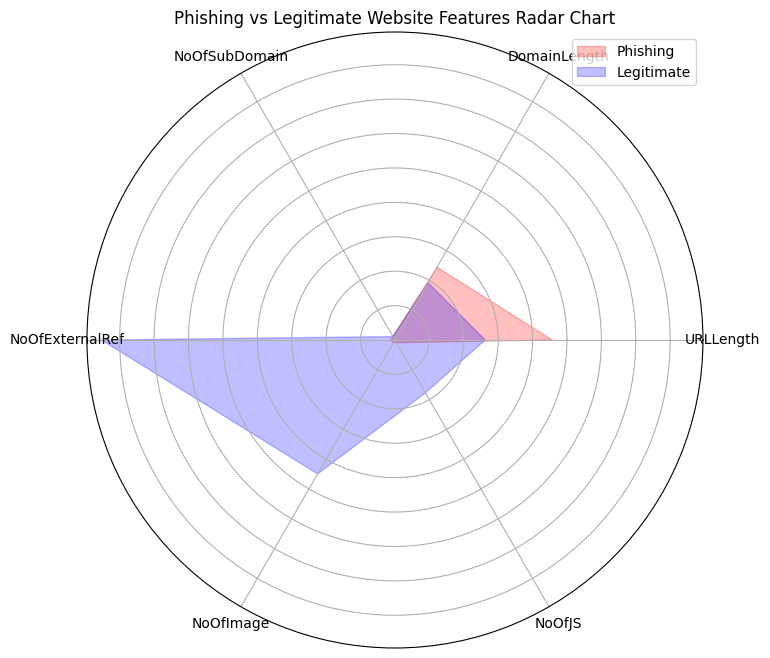

In [18]:
# Le radar chart affiche la moyenne de chaque caractéristique par la variable de label

# Calculer les moyennes
phishing_mean = df[df['label'] == 0].mean()
legit_mean = df[df['label'] == 1].mean()

features = [
    'URLLength', 'DomainLength', 'NoOfSubDomain',
    'NoOfExternalRef', 'NoOfImage', 'NoOfJS',
    ]
phishing_values = [phishing_mean[feature] for feature in features]
legit_values = [legit_mean[feature] for feature in features]

# Add the first value to the end to close the radar chart
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
phishing_values += phishing_values[:1]
legit_values += legit_values[:1]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, phishing_values, color='red', alpha=0.25, label='Phishing')
ax.fill(angles, legit_values, color='blue', alpha=0.25, label='Legitimate')
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
plt.title("Phishing vs Legitimate Website Features Radar Chart")
plt.legend(loc='upper right')
plt.show()

Ici, on voit que la surface bleue pour les sites légitimes s'étend beaucoup plus sur l'axe NoOfExternalRef, ce qui pourrait indiquer que les sites légitimes ont plus de références externes que les sites de phishing. C'est pareil pour l'axe NoOfImage. 

## <font color='red'>Modèles </font> 

Dans cette section, on va explorer des divers modèles, en essayant des hyperparamètres différents et des caractéristiques différentes. L'idée est de trouver un modèle qui maximise bien le F1 score, tout en gardant une certaine simplicité tout en respectant le principe l'Ockam's Razor.

In [19]:
# Mettre les données à l'échelle. 

x_cols = df.columns[~df.columns.str.contains('label')]
scaler = StandardScaler()
scaled_data = DataFrame(scaler.fit_transform(df[x_cols]), columns=df[x_cols].columns)
scaled_data.head()

,URLLength,DomainLength,IsDomainIP,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,...,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,Count,IsSuspicious,URLFeatureSum,url_diff_length
0,-0.086486,0.276436,-0.052087,0.392745,-0.274154,-0.045399,-0.01325,-0.036265,-0.049120,0.527550,...,0.099788,0.182551,0.783327,0.305222,-0.134778,0.464130,1.045229,0.807286,-0.190756,0.784128
1,-0.280125,-0.597807,-0.052087,-1.274652,-0.274154,-0.045399,-0.01325,-0.036265,-0.358502,-1.013227,...,0.301270,0.035622,-0.113046,-0.147555,-0.134778,1.041672,-0.791069,-0.755632,-0.134030,0.784128
2,-0.134896,0.057875,-0.052087,-1.274652,1.389828,-0.045399,-0.01325,-0.036265,-0.152247,0.008551,...,-0.202435,-0.057878,-0.157865,-0.130576,-0.021406,-0.274876,-0.887421,-0.234659,-0.134030,0.784128
3,-0.207510,-0.269966,-0.052087,0.392745,-0.274154,-0.045399,-0.01325,-0.036265,-0.220999,-0.129308,...,-0.290583,0.276051,0.200684,-0.243770,-0.078092,-0.113413,1.045229,0.807286,-0.190756,0.784128
4,-0.038077,0.494997,-0.052087,0.392745,-0.274154,-0.045399,-0.01325,-0.036265,0.019631,0.730284,...,2.744236,0.115765,1.052238,0.039216,-0.078092,0.221935,-0.871928,0.807286,-0.190756,0.784128


Nous avons mis à l'échelle toutes les variables numréquies. Ainsi, on peut explorer des ensembles différents de caractéristiques très facilement.

Nous avons aussi opté dans le cadre de notre étude à la cross validation afin de s'assurer que le modèle se généralise bien.

In [20]:
# Diviser les données en un ensemble d'entraînement et un ensemble de testing. 
X_train, X_test, y_train, y_test = train_test_split(scaled_data, df['label'], test_size=0.1, random_state=42)

# Fonction pour éxecuter un modèle arbitraire avec la validation croisée avec 5 folds.
def cross_validate_model(X_train, y_train, model):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    best_folds = {}

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)

        accuracy_scores.append(accuracy_score(y_val_fold, y_pred))
        precision_scores.append(precision_score(y_val_fold, y_pred))
        recall_scores.append(recall_score(y_val_fold, y_pred))
        f1_score_ = f1_score(y_val_fold, y_pred)

        if not f1_scores:
            best_folds['x_fold'] = X_val_fold
            best_folds['y_fold'] = y_val_fold
        elif f1_score_ > max(f1_scores):
            best_folds['x_fold'] = X_val_fold
            best_folds['y_fold'] = y_val_fold

        f1_scores.append(f1_score_)
    
    return {
        'Accuracy': np.mean(accuracy_scores),
        'Précision': np.mean(precision_scores),
        'Recall': np.mean(recall_scores),
        'F1 Score': np.mean(f1_scores),
        'best_folds': best_folds, # For if ever we want to visualise the results of a model
    }

Nous avons pris deux ensembles de caractéristiques. Le premier se concentre exclusivement sur des celles qui ont été conçues, pendant que le deuxième prend la pluplart des caractéristiques d'origines. Ainsi, on peut voir les effets d'inclure certanies caractéristiques d'origine. L'idée est qu'on va itérativement enlever celles qui ne sont pas pertinentes.

Pour l'ensemble features2, on enlève les variables ratio comme LetterRatioInUrl car l'information se répéte également dans NoOfLettersInUrl sachant qu'on a URLLength. On omet aussi DomainLength puisque l'information est possiblement récupérable à travers is_url_length_equal_to_domain_length et URLLength.

In [43]:
# Les ensembles de caractéristiques qu'on va explorer.
features1 = [
    'IsSuspicious', 'Count', 'URLFeatureSum',
]

features2 = [
    'URLLength',
    'IsDomainIP',
    'NoOfSubDomain', 
    'HasObfuscation', 
    'NoOfObfuscatedChar',
    'NoOfLettersInURL',
    'NoOfDegitsInURL',
    'NoOfEqualsInURL',
    'NoOfQMarkInURL', 
    'NoOfAmpersandInURL',
    'NoOfOtherSpecialCharsInURL', 'IsHTTPS',
    'HasTitle',
    'HasFavicon',
    'Robots',
    'IsResponsive',
    'NoOfURLRedirect',
    'NoOfSelfRedirect',
    'HasDescription',
    'NoOfPopup', 
    'NoOfiFrame',
    'HasExternalFormSubmit',
    'HasSocialNet',
    'HasSubmitButton', 
    'HasHiddenFields', 
    'HasPasswordField',
    'Bank', 'Pay',
    'Crypto',
    'HasCopyrightInfo',
    'NoOfImage', 'NoOfCSS', 'NoOfJS',
    'NoOfEmptyRef', 
    'NoOfSelfRef',
    'NoOfExternalRef',
    'LineOfCode',
    'url_diff_length',
]

### <font color='red'>Régression Logistique </font> 

In [110]:
def run_log_reg(x_train, y_train, features = None, hyperparameters = {}):
    log_reg = LogisticRegression(**hyperparameters)
    x_train = x_train if features is None else x_train[features]
    return cross_validate_model(
        x_train[features],
        y_train,
        log_reg,
    )

# hyperparamères à explorer
solver_penalty_pairs = [
    {'penalty': 'l1', 'solver': 'liblinear'},
    {'penalty': 'l2', 'solver': 'lbfgs'},
    {'penalty': 'l2', 'solver': 'newton-cg'},
    {'penalty': None, 'solver': 'sag'},
]


### Avec les features1

In [111]:
best_solver_penalty = None
best_f1_score = 0

for solver_penalty in solver_penalty_pairs:
    scores = run_log_reg(X_train, y_train, features1, hyperparameters=solver_penalty)
    val_f1_score = scores['F1 Score']
    print(f"F1 Score with {solver_penalty} penalty: {val_f1_score}")
    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_solver_penalty = solver_penalty

print(f"Best kernel: {best_solver_penalty} with F1 Score: {best_f1_score}")

F1 Score with {'penalty': 'l1', 'solver': 'liblinear'} penalty: 0.915020938164982
F1 Score with {'penalty': 'l2', 'solver': 'lbfgs'} penalty: 0.9150211603785829
F1 Score with {'penalty': 'l2', 'solver': 'newton-cg'} penalty: 0.915026849951752


c:\Users\asent\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\asent\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\asent\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\asent\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score with {'penalty': None, 'solver': 'sag'} penalty: 0.914745333310442
Best kernel: {'penalty': 'l2', 'solver': 'newton-cg'} with F1 Score: 0.915026849951752


c:\Users\asent\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Avec les features2

In [112]:
# features2
best_solver_penalty = None
best_f1_score = 0

for solver_penalty in solver_penalty_pairs:
    scores = run_log_reg(X_train, y_train, features2, hyperparameters=solver_penalty)
    val_f1_score = scores['F1 Score']
    print(f"F1 Score with {solver_penalty} penalty: {val_f1_score}")
    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_solver_penalty = solver_penalty

print(f"Best kernel: {best_solver_penalty} with F1 Score: {best_f1_score}")

c:\Users\asent\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\asent\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\asent\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\asent\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\asent\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


F1 Score with {'penalty': 'l1', 'solver': 'liblinear'} penalty: 0.9992256219420655
F1 Score with {'penalty': 'l2', 'solver': 'lbfgs'} penalty: 0.9995010724340669
F1 Score with {'penalty': 'l2', 'solver': 'newton-cg'} penalty: 0.9996041561307013


c:\Users\asent\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\asent\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\asent\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\asent\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


F1 Score with {'penalty': None, 'solver': 'sag'} penalty: 0.9990604494039264
Best kernel: {'penalty': 'l2', 'solver': 'newton-cg'} with F1 Score: 0.9996041561307013


c:\Users\asent\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pour la régression logistique, on voit clairement que l'ensemble de features2 fonctionne mieux. Il y a aussi des problèmes avec la convergence, qui nous indiquent qu'on pourrait obtenier des meilleurs résultats avec d'autres méthodes.

### <font color='red'> Les arbres de décision </font> 

In [113]:
def run_decision_tree(x_train, y_train, features = None, hyperparameters = {}):
    model = DecisionTreeClassifier(**hyperparameters)
    x_train = x_train if features is None else x_train[features]
    return model, cross_validate_model(
        x_train[features],
        y_train,
        model,
    )

# hyperparamères à explorer
splitters = ['best', 'random']
criterions = ['gini', 'entropy', 'log_loss']
max_depths = range(3, 10, 2)

In [114]:
# features1
best_splitter = None
best_criterion = None
best_max_depth = 0
best_f1_score = 0

for splitter in splitters:
    for criterion in criterions:
        for max_depth in max_depths:
            model, scores = run_decision_tree(
                X_train, y_train, features1,
                hyperparameters={
                    'criterion': criterion,
                    'splitter': splitter,
                    'max_depth': max_depth,
                },
            )
            val_f1_score = scores['F1 Score']
            print(f"F1 Score with criterion: {criterion}, max depth {max_depth} and splitter: {splitter}: {val_f1_score}")
            if val_f1_score > best_f1_score:
                best_f1_score = val_f1_score
                best_splitter = splitter
                best_criterion = criterion
                best_max_depth = max_depth

F1 Score with criterion: gini, max depth 3 and splitter: best: 0.902662536363159
F1 Score with criterion: gini, max depth 5 and splitter: best: 0.9203886806622847
F1 Score with criterion: gini, max depth 7 and splitter: best: 0.9258508419711537
F1 Score with criterion: gini, max depth 9 and splitter: best: 0.9301552766742663
F1 Score with criterion: entropy, max depth 3 and splitter: best: 0.902662536363159
F1 Score with criterion: entropy, max depth 5 and splitter: best: 0.9203327602226601
F1 Score with criterion: entropy, max depth 7 and splitter: best: 0.9255911475804179
F1 Score with criterion: entropy, max depth 9 and splitter: best: 0.9295320873429807
F1 Score with criterion: log_loss, max depth 3 and splitter: best: 0.902662536363159
F1 Score with criterion: log_loss, max depth 5 and splitter: best: 0.9203327602226601
F1 Score with criterion: log_loss, max depth 7 and splitter: best: 0.9255911475804179
F1 Score with criterion: log_loss, max depth 9 and splitter: best: 0.92953208

In [115]:
# features2
best_splitter = None
best_criterion = None
best_f1_score = 0

best_splitter = None
best_criterion = None
best_max_depth = 0
best_f1_score = 0

for splitter in splitters:
    for criterion in criterions:
        for max_depth in max_depths:
            model, scores = run_decision_tree(
                X_train, y_train, features2,
                hyperparameters={
                    'criterion': criterion,
                    'splitter': splitter,
                    'max_depth': max_depth,
                },
            )
            val_f1_score = scores['F1 Score']
            print(f"F1 Score with criterion: {criterion}, max depth {max_depth} and splitter: {splitter}: {val_f1_score}")
            if val_f1_score > best_f1_score:
                best_f1_score = val_f1_score
                best_splitter = splitter
                best_criterion = criterion
                best_max_depth = max_depth


F1 Score with criterion: gini, max depth 3 and splitter: best: 0.9936070700242118
F1 Score with criterion: gini, max depth 5 and splitter: best: 0.9956650028845578
F1 Score with criterion: gini, max depth 7 and splitter: best: 0.9990675718507415
F1 Score with criterion: gini, max depth 9 and splitter: best: 0.9995789082926784
F1 Score with criterion: entropy, max depth 3 and splitter: best: 0.9974660610393691
F1 Score with criterion: entropy, max depth 5 and splitter: best: 0.9991298662572758
F1 Score with criterion: entropy, max depth 7 and splitter: best: 0.9997690342085642
F1 Score with criterion: entropy, max depth 9 and splitter: best: 0.9997649189573898
F1 Score with criterion: log_loss, max depth 3 and splitter: best: 0.9974660610393691
F1 Score with criterion: log_loss, max depth 5 and splitter: best: 0.9991298662572758
F1 Score with criterion: log_loss, max depth 7 and splitter: best: 0.9997649293712032
F1 Score with criterion: log_loss, max depth 9 and splitter: best: 0.99976

En utilisant les arbres de décisions, on a pu améliorer les résultats de tous les deux ensembles de caractéristiques. En plus, ce genre modèles éxecute plus rapidement. Etant donné que le deuxième fonctionne assez bien généralement, ce n'est pas surprenant qu'il est moins sensible au paramètre de max_depth. Avec cet ensemble-ci, on peut obtenir plus de simplicité en choissisant un max_depth de 3 sans sacrifier beaucoup les résultats.

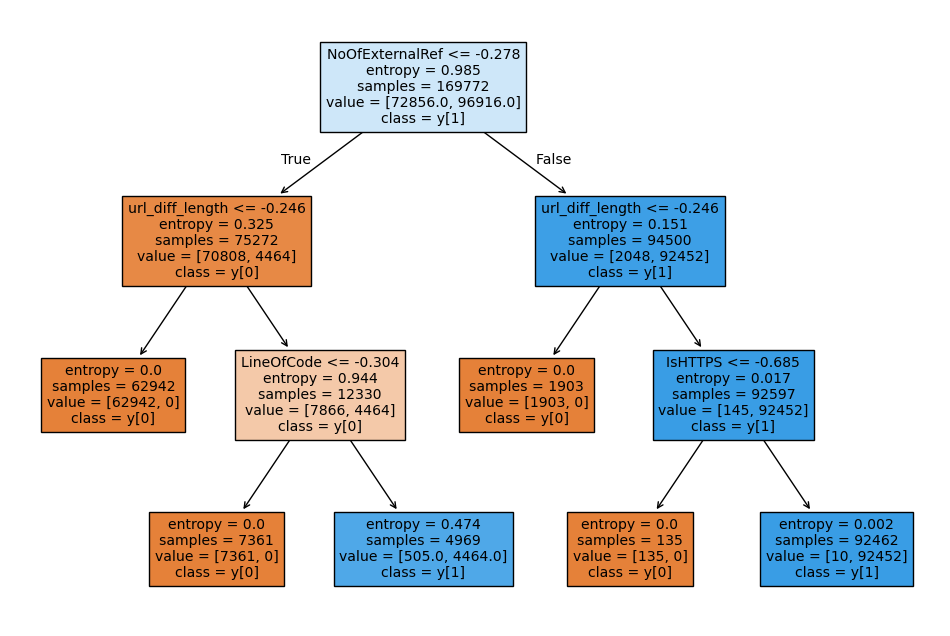

In [116]:
# Prenons le meilleur modèle pour visualiser.
model, scores = run_decision_tree(
    X_train, y_train, features2,
    hyperparameters={'criterion': 'entropy', 'splitter': "best", 'max_depth': 3},
)

plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=features2, class_names=True, filled=True)
plt.show()

Pour chaque arbre de la forêt, l'importance d'une caractéristique est calculée en mesurant combien cette caractéristique réduit l'incertitude (par exemple, en utilisant la réduction de l'entropie dans ce cas) chaque fois qu'elle est utilisée pour diviser les données.

Matrice de Confusion :
 [[17978   101]
 [    0 24364]]


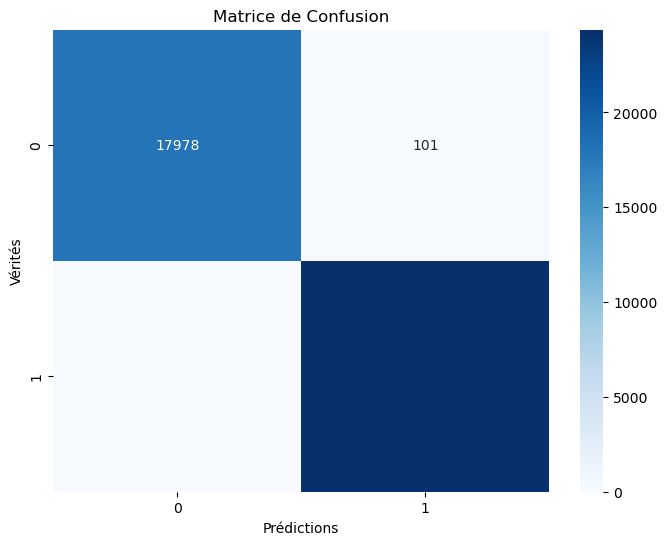

In [117]:
x_valid = scores['best_folds']['x_fold']
y_valid = scores['best_folds']['y_fold']

y_pred = model.predict(x_valid)

conf_matrix = confusion_matrix(y_valid, y_pred)
print("Matrice de Confusion :\n", conf_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')
plt.show()

On remarque qu'on obtient seulement 101 erreurs sur les faux négatifs. C'est à dire ce sont des sites phishing qui sont considérés comme bons sites. On souhaite bien sûr diminuer au maximum ce nombre afin que le modèle de prédiction soit fiable à l'utilisation.

### <font color='red'> Des fôrets aléatoires </font> 

On teste cette fois les forêts aléatoires qui reprend l'idée des arbres de décision mais sous une forme plus complexe afin d'obtenir de meilleurs résultats

In [56]:
def run_random_forest(x_train, y_train, features = None, hyperparameters = {}):
    model = RandomForestClassifier(**hyperparameters)
    x_train = x_train if features is None else x_train[features]
    return model, cross_validate_model(
        x_train[features],
        y_train,
        model,
    )

# hyperparamètres
class_weights = ['balanced', 'balanced_subsample']

In [57]:
best_class_weight = None
best_f1_score = 0

for class_weight in class_weights:
    model, scores = run_random_forest(X_train, y_train, features2, hyperparameters={"n_estimators": 100, "class_weight": class_weight})
    val_f1_score = scores['F1 Score']
    print(f"F1 Score with {class_weight} class weight: {val_f1_score}")
    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_class_weight = class_weight

print(f"Best class weight: {best_class_weight} with F1 Score: {best_f1_score}")

F1 Score with balanced class weight: 0.9999546145905891
F1 Score with balanced_subsample class weight: 0.9999463025667072
Best class weight: balanced with F1 Score: 0.9999546145905891


Ici, nous se concentrons exclusivement sur le deuxième ensemble de caractéristiques. En effet, nous avons testé plusieurs valeurs de n_estimators. Cependant, nous avons fini par choisir la valeur de défault 100 puisqu'on obtient avec les meilleurs résultats. 

F1 Score: 1.0
accuracy : 1.0
Matrice de Confusion :
 [[18079     0]
 [    0 24364]]


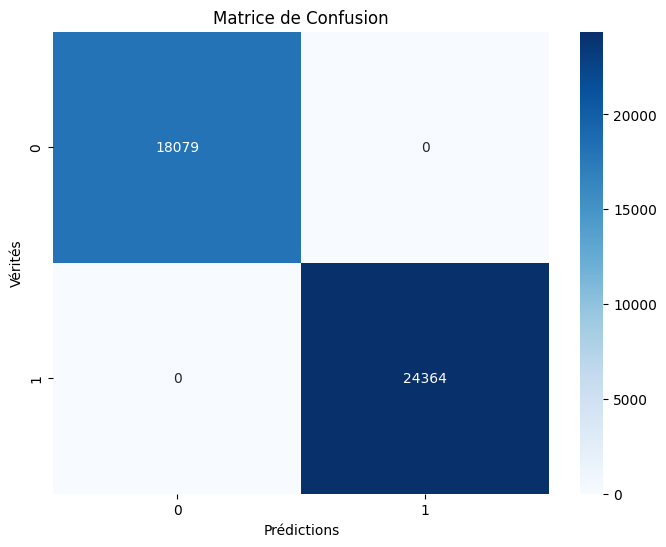

In [58]:
best_rf_model, best_rf_scores = run_random_forest(
    X_train, y_train, features2,
    hyperparameters={"n_estimators": 100, "class_weight": "balanced_subsample"}
)

x_valid = best_rf_scores['best_folds']['x_fold']
y_valid = best_rf_scores['best_folds']['y_fold']

y_pred = best_rf_model.predict(x_valid)

f1 = f1_score(y_valid, y_pred, average='weighted')  # 'weighted' pour tenir compte de la classe majoritaire/minoritaire
print("F1 Score:", f1)

accuracy = accuracy_score(y_valid, y_pred)
print("accuracy :", accuracy)

conf_matrix = confusion_matrix(y_valid, y_pred)
print("Matrice de Confusion :\n", conf_matrix)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.title('Matrice de Confusion')
plt.show()

On remarque qu'on a un résultat quasi parfait avec seulement une seule erreur.

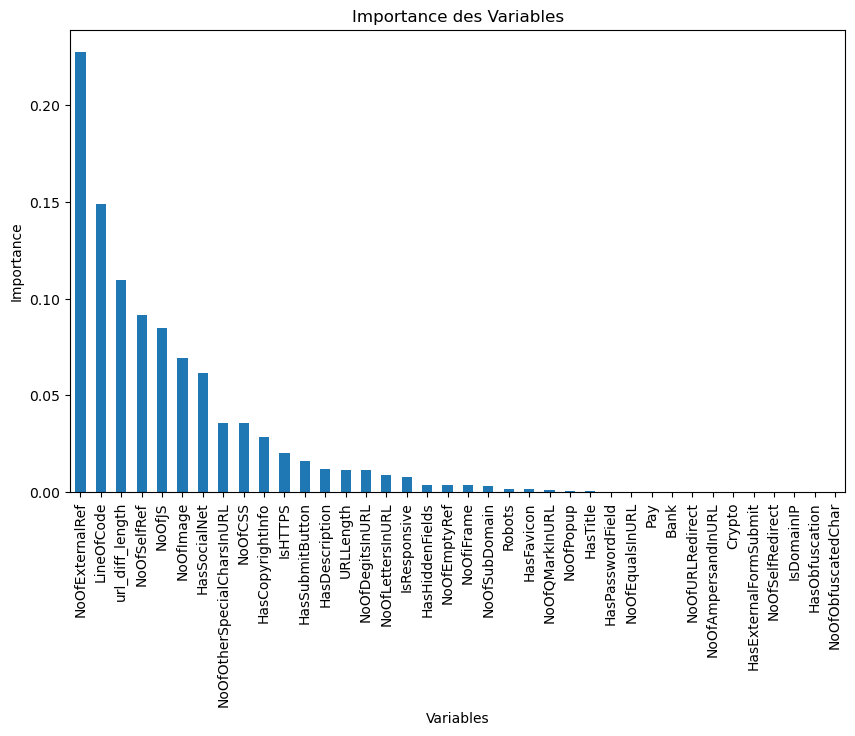

In [121]:
def plot_feature_importance(model, X_train):
  feature_importances = model.feature_importances_

  # Afficher les importances sous forme de graphique
  features = X_train.columns
  importances = Series(
    feature_importances,
    index=features,
  ).sort_values(ascending=False)

  plt.figure(figsize=(10, 6))
  importances.plot(kind='bar')
  plt.title('Importance des Variables')
  plt.xlabel('Variables')
  plt.ylabel('Importance')
  plt.show()
  pass

plot_feature_importance(best_rf_model, X_train[features2])

On remarque que de nombreuses variables ont eu peu d'importance dans la décision de prédiction, voire aucune importance. Pour cette raison, et selon le principe Occams Razor, on essaiera d'obtenir des résultats similaires mais avec moins de variables. 

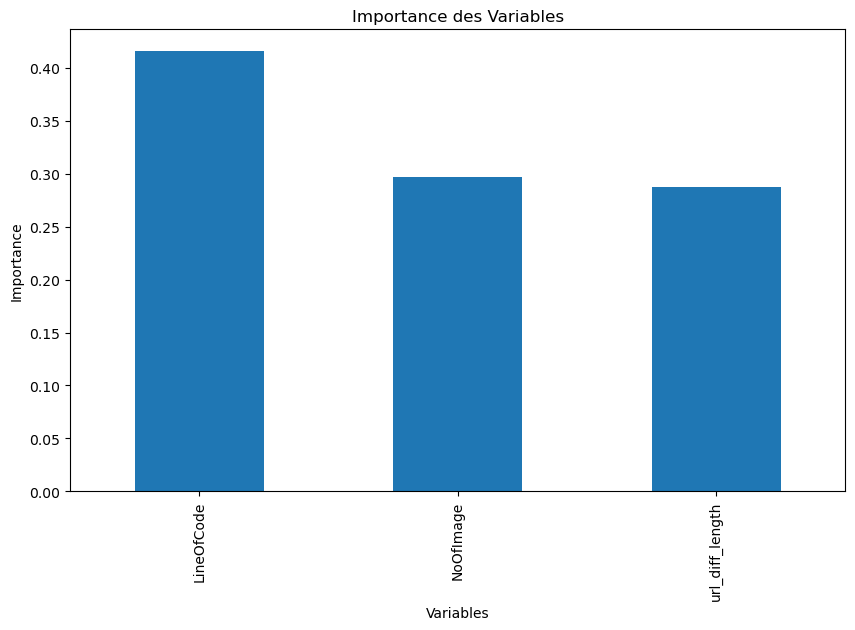

In [122]:
features3 = [
    "url_diff_length",
    "LineOfCode",
    'NoOfImage',
]

best_rf_model, best_rf_scores = run_random_forest(
    X_train, y_train, features3,
    hyperparameters={
        "n_estimators": 100,
        "class_weight": "balanced_subsample",
    }
)

plot_feature_importance(best_rf_model, X_train[features3])

In [123]:
best_rf_scores['F1 Score']

0.9982885550789344

Avec 3 variables, on obtient toujours 99% de F1 score, avec plus d'erreurs mais ça reste relativement très bas vu la quantité énorme de donnée de test.
On essaye maintenant en enlevant NoOfImage.

F1 Score 0.9977790394807565


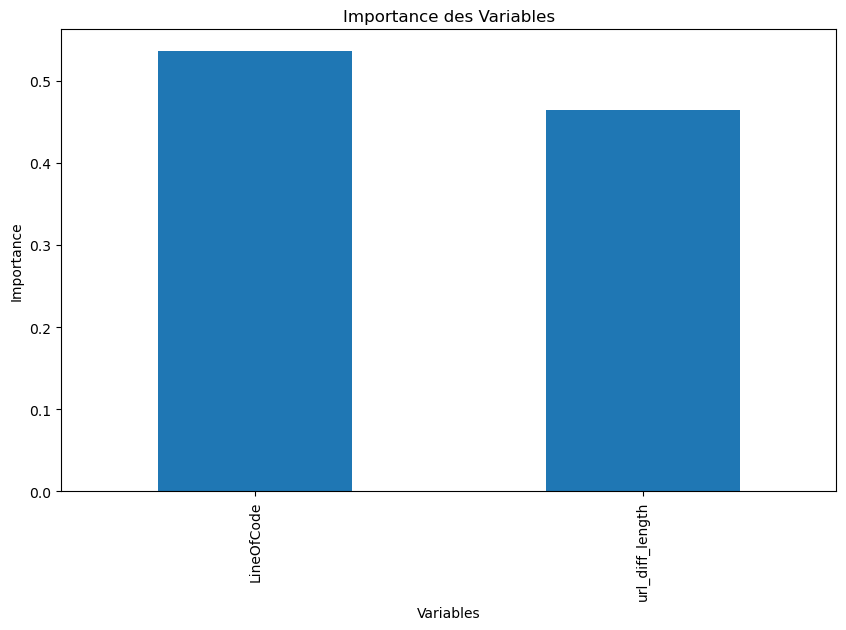

In [124]:
features4 = [
    "url_diff_length",
    "LineOfCode",
]

best_rf_model, best_rf_scores = run_random_forest(
    X_train, y_train, features4,
    hyperparameters={
        "n_estimators": 100,
        "class_weight": "balanced_subsample",
    }
)

print("F1 Score", best_rf_scores['F1 Score'])
plot_feature_importance(best_rf_model, X_train[features4])

### <font color='red'> SVC </font> 

In [44]:
def run_svc(x_train, y_train, features = None, hyperparameters = {}):
    model = SVC(**hyperparameters)
    x_train = x_train if features is None else x_train[features]
    return cross_validate_model(
        x_train,
        y_train,
        model,
    )

In [48]:
kernels = ['linear'] # 'poly', 'rbf'

best_kernel = None
best_f1_score = 0

for kernel in kernels:
    scores = run_svc(X_train, y_train, features4, hyperparameters={'kernel': kernel})
    val_f1_score = scores['F1 Score']
    print(f"F1 Score with {kernel} kernel: {val_f1_score}")
    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_kernel = kernel

print(f"Best kernel: {best_kernel} with F1 Score: {best_f1_score}")

F1 Score with linear kernel: 0.996889609071508
Best kernel: linear with F1 Score: 0.996889609071508


### <font color='red'> Neural Networks </font> 

In [21]:
# Construire le modèle de réseau de neurones avec Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Utiliser une activation sigmoïde pour la classification binaire
])

# Compiler le modèle
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

c:\Users\edgar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.9953 - loss: 0.0209 - val_accuracy: 0.9996 - val_loss: 0.0014
Epoch 2/10
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 5s 995us/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.9995 - val_loss: 0.0015
Epoch 3/10
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 5s 957us/step - accuracy: 0.9997 - loss: 9.1673e-04 - val_accuracy: 0.9998 - val_loss: 0.0012
Epoch 4/10
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 5s 984us/step - accuracy: 0.9997 - loss: 8.1718e-04 - val_accuracy: 0.9997 - val_loss: 0.0014
Epoch 5/10
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.9998 - loss: 6.3379e-04 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 6/10
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9998 - loss: 5.1650e-04 - val_accuracy: 0.9997 - val_loss: 0.0015
Epoch 7/10
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9998 - loss: 7.1156e-04 - val_accuracy: 0.9992 - val_loss: 0.0028
Epoch 8/10
5306/5306 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy

In [28]:
# Évaluer le modèle sur les données de test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

# Convertir les prédictions en étiquettes binaires (si nécessaire)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Calculer le F1 score
f1 = f1_score(y_test, y_pred_classes)

print("Test Accuracy:", test_accuracy)
print("F1 Score:", f1)

737/737 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.9997 - loss: 0.0015
737/737 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step
Test Accuracy: 0.9997455477714539
F1 Score: 0.999778891509434


### <font color='red'> Gradient Boosting </font> 

In [ ]:
def run_gradient_boosting(x_train, y_train, features = None, hyperparameters = {}):
    model = GradientBoostingClassifier(**hyperparameters)
    x_train = x_train if features is None else x_train[features]
    return cross_validate_model(
        x_train,
        y_train,
        model,
    )

losses = ['log_loss', 'exponential']
criterions = ['squared_error', 'friedman_mse']

In [ ]:
best_loss = None
best_criterion = None
best_f1_score = 0

for loss in losses:
    for criterion in criterions:
        scores = run_gradient_boosting(
            X_train, y_train, features4,
            hyperparameters={'criterion': criterion, 'loss': loss},
        )
        val_f1_score = scores['F1 Score']
        print(f"F1 Score with criterion: {criterion} and loss: {loss}: {val_f1_score}")
        if val_f1_score > best_f1_score:
            best_f1_score = val_f1_score
            best_loss = loss
            best_criterion = criterion
            
print(f"Best kernel: {best_kernel} with F1 Score: {best_f1_score}")

F1 Score with criterion: squared_error and loss: log_loss: 0.9978839887809313
F1 Score with criterion: friedman_mse and loss: log_loss: 0.9978839887809313
F1 Score with criterion: squared_error and loss: exponential: 0.9977263359259243
F1 Score with criterion: friedman_mse and loss: exponential: 0.9977263359259243
Best kernel: linear with F1 Score: 0.9978839887809313


### <font color='red'> Naive Bayes </font> 

In [ ]:
def run_naive_bayes(x_train, y_train, features = None, hyperparameters = {}):
    model = GaussianNB(**hyperparameters)
    x_train = x_train if features is None else x_train[features]
    return cross_validate_model(
        x_train,
        y_train,
        model,
    )

In [ ]:
scores = run_naive_bayes(X_train, y_train, features4)
scores['F1 Score']

0.9601099197086949

Les modèles de Gradient Boosting, Naive Bayes, et SVM tous fonctionnent assez bien. Cependant, leurs performances sont plutôt comparables à celle des forêts aléatoires, et ils sont généralement moins rapides. Donc, on prend le modèle suivant comme préféré :

Forêts aléatoires : n_estimators = 100, class_weight = balanced_subsample

## <font color='red'> Analyse de Sensibilité </font> 

Ici, nous allons voir comment la performance de notre modèle change en fonction des variables interdites. Avec les caractéristiques de is_url_length_equal_to_domain_length et LineOfCode, on ajoute chaque variable interdite pour voir l'effet.

In [ ]:
to_scale = base_data.select_dtypes((float, int))

# Re-add feature in features4 list
to_scale["url_diff_length"] = ((to_scale["URLLength"] - 7) == to_scale["DomainLength"]).astype(int)

x_cols = to_scale.columns[~to_scale.columns.str.contains('label')]
scaler = StandardScaler()

scaled_continues = DataFrame(
    scaler.fit_transform(to_scale[x_cols]),
    columns=to_scale[x_cols].columns,
)

X_train, X_test, y_train, y_test = train_test_split(
    scaled_continues, to_scale['label'], test_size=0.1, random_state=42,
)

In [ ]:
best_column = ''
best_f1_score = 0

for column in drop_columns:
    model, scores = run_random_forest(
        X_train,
        y_train,
        [*features4, column],
        hyperparameters={
            "n_estimators": 100,
            "class_weight": 'balanced_subsample',
        },
    )
    val_f1_score = scores['F1 Score']

    print(f"F1 Score with {column} column: {val_f1_score}")
    if val_f1_score > best_f1_score:
        best_f1_score = val_f1_score
        best_column = column

F1 Score with URLSimilarityIndex column: 0.9999834954327904
F1 Score with CharContinuationRate column: 0.9981950866432797
F1 Score with URLTitleMatchScore column: 0.9982604119501637
F1 Score with URLCharProb column: 0.9978905050047413
F1 Score with TLDLegitimateProb column: 0.9984208531451865


On peut voir que la variable qui améliore le F1 score le plus est celle de URLSimilarityIndex. Cependant, étant donné que le F1 score était déjà environ 0,99, l'effet des variables interfites est négligible.

## <font color='red'> Données d'évaluation </font> 

Dans cette section, on prend notre meilleur modèle, celui des forêts aléatoires avec un class weight de balanced_subsample, pour l'entraîner et le tester sur les nouvelles données.

In [49]:
training_data = read_csv('datasets/Training_for_evaluation.csv')
testing_data = read_csv('datasets/Testing_for_evaluation.csv')

In [50]:
# Re-add feature in features4 list
training_data["url_diff_length"] = ((training_data["URLLength"] - 7) == training_data["DomainLength"]).astype(int)


In [52]:
final_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample')
final_model.fit(training_data[features4], training_data['label'])

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [53]:

testing_data["url_diff_length"] = ((testing_data["URLLength"] - 7) == testing_data["DomainLength"]).astype(int)
y_pred_final = final_model.predict(testing_data[features4])

In [59]:
f1 = f1_score(y_valid, y_pred, average='weighted')  # 'weighted' pour tenir compte de la classe majoritaire/minoritaire
print("F1 Score:", f1)

accuracy = accuracy_score(y_valid, y_pred)
print("accuracy :", accuracy)

conf_matrix = confusion_matrix(y_valid, y_pred)
print("Matrice de Confusion :\n", conf_matrix)

F1 Score: 1.0
accuracy : 1.0
Matrice de Confusion :
 [[18079     0]
 [    0 24364]]


Nous obtenons quasiment les mêmes résultats que pour l'ancien dataset, et avec le moins de features possibles.
